### Importing dependencies

In [18]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the EfficientNet Model Architecture

> Add blockquote



In [22]:

import torch
from torch import nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=4):
        super(SEBlock, self).__init__()
        reduced_dim = in_channels // reduction_ratio
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio):
        super(MBConvBlock, self).__init__()
        self.use_res_connect = stride == 1 and in_channels == out_channels
        hidden_dim = in_channels * expand_ratio
        self.expansion = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ) if expand_ratio != 1 else nn.Identity()

        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        )

        self.se = SEBlock(hidden_dim)

        self.pointwise = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion(x)
        out = self.depthwise(out)
        out = self.se(out)
        out = self.pointwise(out)
        if self.use_res_connect:
            out = out + x
        return out

class EfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNet, self).__init__()
        # Adjust the initial number of channels and the number of output classes
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # Define a series of MBConv blocks
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, 3, 1, 1),
            MBConvBlock(16, 24, 3, 2, 6),  # Downsample
            MBConvBlock(24, 40, 5, 2, 6),  # Downsample
            # More blocks can be added here with appropriate parameters
        )

        self.head = nn.Sequential(
            nn.Conv2d(40, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Perform a sanity check for the correctness of the model

In [23]:
net = EfficientNet(num_classes=4)
net = net.to(device)
data = torch.randn(5,3,64,64)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
928
Sequential(
  (0): MBConvBlock(
    (expansion): Identity()
    (depthwise): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (se): SEBlock(
      (se): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (pointwise): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

### Move data and the model to the GPU

In [24]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Tue Apr 23 17:07:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              29W /  70W |    855MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [25]:
# hyperparameters
INITIAL_LR = 0.1 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [26]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'efficientnet.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.6356, Training accuracy: 0.6468


validating...: 0it [00:00, ?it/s]

Validation loss: 4.8693, Validation accuracy: 0.7177
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 0.5615, Training accuracy: 0.8027


validating...: 0it [00:00, ?it/s]

Validation loss: 1.0046, Validation accuracy: 0.7656
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 0.5533, Training accuracy: 0.8017


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9612, Validation accuracy: 0.7715
Saving ...

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.4511, Training accuracy: 0.8184


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4719, Validation accuracy: 0.8062
Saving ...

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.3906, Training accuracy: 0.8317


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5004, Validation accuracy: 0.7919

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.3718, Training accuracy: 0.8328


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3950, Validation accuracy: 0.8182
Saving ...

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.3775, Training accuracy: 0.8311


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4056, Validation accuracy: 0.8098

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.3617, Training accuracy: 0.8324


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3979, Validation accuracy: 0.8170

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.3551, Training accuracy: 0.8403


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4043, Validation accuracy: 0.8230
Saving ...

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.3391, Training accuracy: 0.8403


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3949, Validation accuracy: 0.8206

Current learning rate has decayed to 0.100000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.3302, Training accuracy: 0.8451


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5180, Validation accuracy: 0.8014

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.3174, Training accuracy: 0.8539


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3406, Validation accuracy: 0.8313
Saving ...

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.3101, Training accuracy: 0.8601


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3517, Validation accuracy: 0.8624
Saving ...

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.2946, Training accuracy: 0.8662


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3540, Validation accuracy: 0.8840
Saving ...

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.2835, Training accuracy: 0.8693


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3422, Validation accuracy: 0.8553

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.2800, Training accuracy: 0.8754


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3029, Validation accuracy: 0.8732

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.2775, Training accuracy: 0.8792


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3239, Validation accuracy: 0.8589

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.2545, Training accuracy: 0.8894


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3514, Validation accuracy: 0.8301

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.2463, Training accuracy: 0.8922


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3813, Validation accuracy: 0.8708

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.3988, Training accuracy: 0.8747


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3814, Validation accuracy: 0.8756

Current learning rate has decayed to 0.100000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.3420, Training accuracy: 0.8628


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3397, Validation accuracy: 0.8660

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.2799, Training accuracy: 0.8915


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5077, Validation accuracy: 0.8218

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.2715, Training accuracy: 0.8843


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7258, Validation accuracy: 0.8266

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.2392, Training accuracy: 0.9055


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3869, Validation accuracy: 0.8230

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2278, Training accuracy: 0.9078


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6901, Validation accuracy: 0.7440

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.2294, Training accuracy: 0.9099


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5003, Validation accuracy: 0.8421

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.2125, Training accuracy: 0.9212


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2920, Validation accuracy: 0.8732

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.2239, Training accuracy: 0.9085


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3742, Validation accuracy: 0.8230

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.2080, Training accuracy: 0.9198


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2499, Validation accuracy: 0.9067
Saving ...

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.1962, Training accuracy: 0.9256


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2462, Validation accuracy: 0.8935

Optimization finished: best validation accuracy is 0.9067


### Show the plots of the training and validation losses

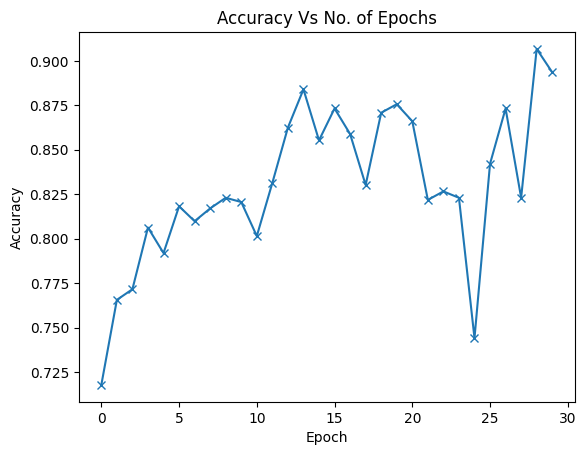

In [27]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

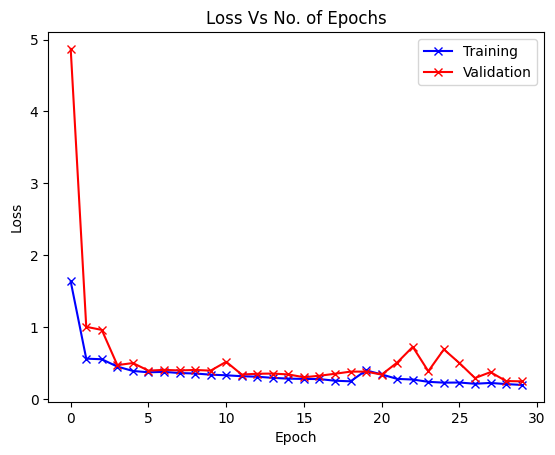

In [28]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

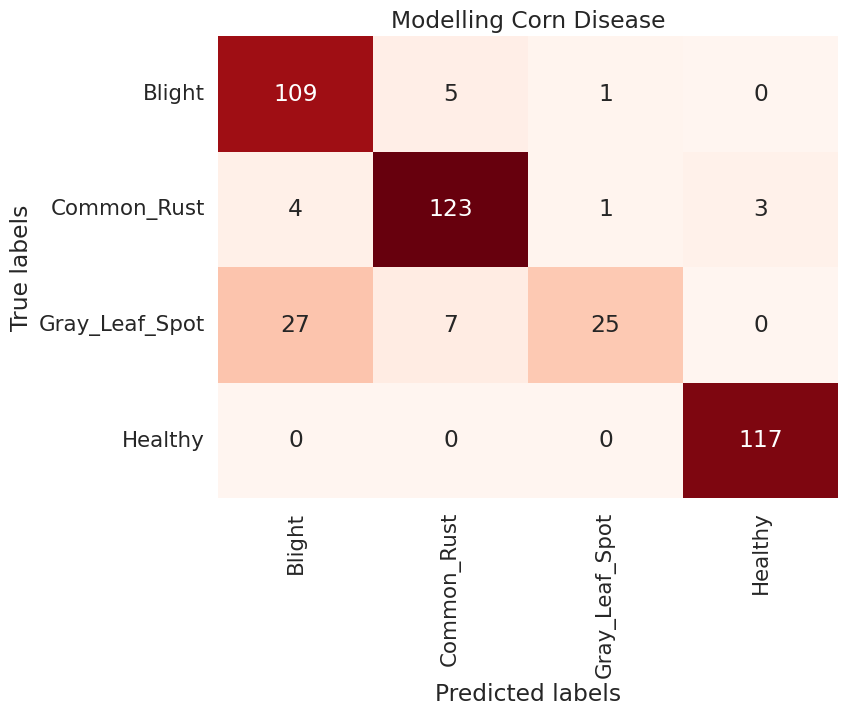

In [29]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

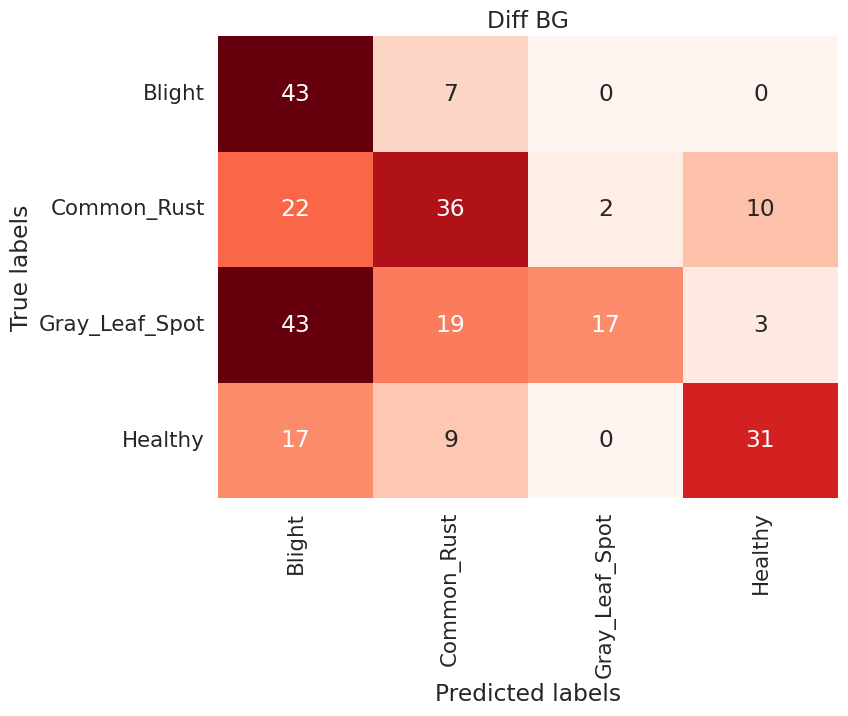

In [30]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()